Data: https://www.kaggle.com/code/eyadgk/bird-species-classification-inceptionv3-95-acc

In [ ]:
import os
import math
import torch
import pickle
import random
import zipfile
import torchvision
import collections
import numpy as np
import pandas as pd
from time import time
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm.notebook import tqdm, trange
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, classification_report, f1_score

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"Current device: {device}")
# from google.colab import drive
# drive.mount('/content/drive')
# root = os.path.join("/","content", "drive", "MyDrive", "datasets")
# birds_path = os.path.join(root, "birds")
# os.chdir(root)
# print(f"root: {root}")

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
root = os.getcwd()
birds_path = os.path.join(root, "birds")
metrics__ = ["loss", "accuracy", "precision", "recall", "f1"]

In [ ]:
# #unzip dataset (only one time)
# zf = zipfile.ZipFile(os.path.join(root, "training_set.zip"))
# for file in tqdm(zf.infolist()):
#     zf.extract(file, birds_path)

In [ ]:
def show_batch_img(batch_x, batch_y=None, ncols=5, type_flag=0, mult=3, suptitle=None):
    count_ = batch_x.size(0)
    nrows = math.ceil(count_/ncols)

    fig, ax = plt.subplots(
        figsize=(16,mult*nrows),ncols=ncols, nrows=nrows, sharex=True, sharey=True);
    if suptitle:
        fig.suptitle(suptitle, fontsize=30)
    ax = [axij for axi in ax for axij in axi]
    for i, img in enumerate(batch_x):
        if batch_y != None:
            title = dataset.classes[batch_y[i]]
        else:
            title = None
        ax[i]
        show_img(img, title=title, ax_flag=ax[i], type_flag=type_flag)
    for axi in ax[i+1:]:
        axi.remove()

def get_counts_by_class(dataset, subset=None):
    if subset:
        class_counts = collections.Counter(
            np.array(dataset.targets)[subset.indices])
    else:
        class_counts = collections.Counter(dataset.targets)
    df_classes = pd.DataFrame.from_dict(class_counts, orient='index').merge(
        pd.DataFrame.from_dict(dataset.class_to_idx, orient='index'),
        left_index=True,
        right_on=0,
        how="inner"
    ).drop(columns=["key_0", "0_y"]).reset_index()
    df_classes.columns=["name", "count"]
    return df_classes

def barplot_(df_classes, figsize=(20,3), fnt_x=20,
             title="Количество экземпляров каждого вида птиц в датасете"):
    cmap = sns.color_palette("light:#5A9", as_cmap=True)
    plt.figure(figsize=figsize)
    sns.barplot(x=df_classes["name"], y=df_classes["count"], palette="dark");
    plt.xticks(rotation = 'vertical', fontsize=fnt_x);
    plt.xlabel("Название вида птиц", fontsize=20)
    plt.ylabel("Количество\nэкземпляров", fontsize=20)
    plt.title(title, fontsize=25)
    plt.show()

def show_img(image, title=None, figsize=(3,3), ax_flag=None, type_flag=0):
    std_, mean_ = std.to(device), mean.to(device)
    if not ax_flag:
        fig, ax = plt.subplots(1, figsize=figsize)
    else:
        ax = ax_flag
    if title:
        ax.set_title(title)
    if type_flag == 0:
        image_ = (image * std_.view(-1, 1, 1)) + mean_.view(-1, 1, 1)
        image_ = image_.cpu().detach().numpy()
        image_ = np.transpose(image_, (1, 2, 0))
    elif type_flag == 1:
        image_ = (image - image.min()) / (image.max()-image.min())
        image_ = image_.cpu().detach().numpy()
    ax.imshow(image_, cmap="Greys")
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    if not ax_flag:
        plt.show()

def get_subset_indexes(dataset, count_ = 400, classes_count=5):
    targets = np.array(dataset.targets)
    subset_indexes = np.empty(0, dtype=np.int32)

    for i in range(classes_count):
        samples = np.random.choice(
            np.where(targets == i)[0],
            size=count_,
            replace=False)
        subset_indexes = np.concatenate((subset_indexes, samples))
    return subset_indexes


def get_metrics(y_true, y_pred, average="weighted", zero_division=0):
    y_true, y_pred = y_true.cpu(), y_pred.cpu()
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred,
                              average=average, zero_division=zero_division)
    recall = recall_score(y_true, y_pred,
                        average=average, zero_division=zero_division)
    f1 = f1_score(y_true, y_pred,
                average=average, zero_division=zero_division)
    return acc, precision, recall, f1

def train(model, train_dl, optimizer, criterion):
    model.train()
    train_loss = 0
    y_true = torch.empty(0).to(device)
    y_pred = torch.empty(0).to(device)

    for inputs, targets in tqdm(train_dl, leave=False, desc='train'):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.squeeze())

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        pred_ = torch.max(outputs, 1)[1]
        y_true = torch.cat((y_true, targets))
        y_pred = torch.cat((y_pred, pred_))

    return y_true, y_pred, train_loss

def test(model, test_dl, criterion):
    model.eval()
    test_loss = 0
    y_true = torch.empty(0).to(device)
    y_pred = torch.empty(0).to(device)
    with torch.no_grad():
        for inputs, targets in tqdm(test_dl, leave=False, desc='test'):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets.squeeze())

            test_loss += loss.item()
            pred_ = torch.max(outputs, 1)[1]
            y_true = torch.cat((y_true, targets))
            y_pred = torch.cat((y_pred, pred_))

    return y_true, y_pred, test_loss

def results_df(params=None):
    return pd.DataFrame(
        data=params,
        columns=["epoch", "type", *metrics__],
    ).set_index(["epoch", "type"])


def train_model(model, train_dl, test_dl, optimizer, criterion, num_epochs=10,
                patience=2, early_stopping=3, factor=0.2):
    start_time = time()
    results = results_df()
    previous = 9999999999
    best_epoch = 0
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 'min', patience=patience, factor=factor,
        verbose=True, min_lr=0.000001)

    for epoch in range(num_epochs):
        y_true, y_pred, train_loss = train(model, train_dl, optimizer, criterion)

        temp = [[epoch, "train", train_loss, *get_metrics(y_true, y_pred)]]
        results = pd.concat((results, results_df(temp)))

        y_true, y_pred, validation_loss = test(model, validation_dl, criterion)

        temp = [[epoch, "validation", validation_loss, *get_metrics(y_true, y_pred)]]
        results = pd.concat((results, results_df(temp)))

        val_acc = results.loc[(epoch, 'validation'), 'accuracy']
        if previous-validation_loss > 0.001:
            previous = validation_loss
            best_epoch = epoch
            print(f"epoch {epoch+1}: model saved")
            torch.save(model.state_dict(), "temp.pth")
        else:
            if epoch - best_epoch > early_stopping:
                break

        scheduler.step(validation_loss)
        print(f"\r#Эпоха [{epoch+1:2}]: train loss [{train_loss:.4f}],",
              f"validation loss [{validation_loss:.4f}],",
              f"train accuracy [{results.loc[(epoch, 'train'), 'accuracy']:.4f}],",
              f"validation accuracy [{val_acc:.4f}]")

    model.load_state_dict(torch.load("temp.pth"))

    time_ = time()-start_time
    print(f"time: {time_/60:.2f} minutes")
    return results, time_

def plot_metric(result_df, type_="loss", ax_flag=None,
                figsize=(14,5), fontsize=16, show_ylabel=True,
                title=False, show_xlabel=True, twinx=False):
    if not ax_flag:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        ax = ax_flag
    xs = pd.IndexSlice
    plt1, = ax.plot(
        result_df.loc[xs[:,"train"], type_].values,
        label=f"train {type_}",
        color="#F3A505",
        linewidth = 3)
    if twinx:
        ax2 = ax.twinx()
    else:
        ax2 = ax
    plt2, = ax2.plot(
        result_df.loc[xs[:,"validation"], type_].values,
        label=f"validation {type_}",
        color="#2E8B57",
        linewidth = 3)
    if title:
        ax.set_title(type_)
    ax.legend(handles=[plt1, plt2], fontsize=fontsize)

    if show_xlabel:
        ax.set_xlabel("Номер эпохи", fontsize=fontsize)
    if show_ylabel:
        ax.set_ylabel(type_, fontsize=fontsize, rotation=90)
    ax.grid(which="both", color="#d0d0d0", linestyle="dashed")
    if not ax_flag:
        plt.show()

def plot_metrics(result_df, figsize=(18,10), fontsize=10, title=True):
    fig, ax = plt.subplots(figsize=figsize, nrows=3, ncols=2, sharex=True)
    ax = [axij for axi in ax for axij in axi]
    ax[-1].remove()
    for i, type_ in enumerate(metrics__[:0:-1]):
        plot_metric(result_df[0], type_=type_, ax_flag=ax[i], show_xlabel=False,
                    fontsize=fontsize, show_ylabel=False, title=True)
    plot_metric(result_df[0], type_=metrics__[0], ax_flag=ax[i+1], show_xlabel=False,
                    fontsize=fontsize, show_ylabel=False, title=True, twinx=True)

def heatmap_(y_true, y_pred, classes=None, fontsize=12, figsize=(14,10)):
    plt.figure(figsize=figsize)
    heatmap = sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap='Greens');
    if classes:
        x = np.unique(y_true).astype("int")
        x.sort()
        classes = np.array(classes)[x]
        heatmap.set_yticklabels(classes, rotation = 0, fontsize = fontsize)
        heatmap.set_xticklabels(classes, rotation =90, fontsize = fontsize);
    plt.show()

def show_layers_result(iter_, layers_count=3):
    for xi, yi in test_dl:
        ind = random.randint(0, xi.size(0)-1)
        show_img(xi[ind], title=dataset.classes[yi[ind]])
        xi_xurr = xi
        for i in range(layers_count):
            layer = next(iter_)
            xi_sub = layer(xi_xurr)
            show_batch_img(xi_sub[ind], ncols=8, mult=2,
                           type_flag=1, suptitle=f"{i+1} layer")
            xi_xurr = xi_sub
        break

#### 1. Выбрать (собрать) набор данных для анализа в соответствии с выбранной темой курсовой работы. Описать этот набор и решаемую задачу. Определить метрики качества для модели, определить типичный уровень метрик для решения аналогичных задач, установить ориентиры для метрики.
Для решения задачи классификации взят набор данных о 25 видах птиц. Каждый класс содержит примерно 900 изображений птиц. Данные представлены в виде изображений в трехцветной кодировке, в .jpg формате. Каждый класс изображений находится в отдельной папке. Все папки для удобства собраны в архив.
Если изучить результаты работы различных людей на сайте kaggle, с которого и был взят данный датасет, то можно заметить, что в среднем модель обучают на 90%-95% accuracy. Но это при условии обучения на полном датасете и с немалым количеством эпох, что требует значительных ресурсов. Google colab предоставляет возможность обучать модели на GPU, но сильно ограничивает скорость загрузки данных с диска, да и в целом предоставляет ограниченные ресурсы. К тому может отнять имеющуюся среду выполнения в любой момент, а тесты показали, что скорость обучения на GPU, предоставляемым Google Colab всего-то в 1.3-1.5 раз выше, чем скорость обучения на процессоре моего ПК. К тому же время обучения модели в примерах на kaggle примерно 10-12 часов. Поэтому будем использовать ограниченный датасет, и к тому же основная цель состоит не в получении превосходящих (или таких же) результатов, а в демонтрации эффективности дропаута для проблемы переобечения нейронных сетей. Но стремиться будем в любом случае к лучшей точности. Используемые метрики будут: accuracy, precision, recall, f1 score. Ориентироваться будем на accuracy 90-95%, но возможно такой точности и не достигнем.

Загрузим данные, применив уменьшив разрешение до 224 на 224 пикселя. Преобразуем входные данные в тензоры и нормализуем их с очень известными значениями mean и std. Данные будем читать батчами по размерностью 32.

In [ ]:
mean = torch.tensor((0.485, 0.456, 0.406))
std = torch.tensor((0.229, 0.224, 0.225))
img_size = (224, 224)
transform =transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
#     transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    transforms.Normalize(mean=mean, std=std),
])
dataset = datasets.ImageFolder(birds_path, transform=transform)
subset = Subset(dataset, get_subset_indexes(dataset, count_=600, classes_count=10))

train_set, validation_set, test_set =  random_split(subset.indices, [0.6, 0.2, 0.2])

train_set = Subset(dataset, train_set.dataset[train_set.indices])
validation_set = Subset(dataset, validation_set.dataset[validation_set.indices])
test_set = Subset(dataset, test_set.dataset[test_set.indices])

batch_size = 32
train_dl = DataLoader(train_set, batch_size=batch_size, shuffle=True)
validation_dl = DataLoader(validation_set, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(validation_set, batch_size=batch_size, shuffle=False)

сохранение состояния (конкретного набора данных, на которых проводилось исследование)

In [ ]:
# with open('sets.pkl', 'wb') as fp:
#     pickle.dump(train_dl, fp)
#     pickle.dump(validation_dl, fp)
#     pickle.dump(test_dl, fp)

Загрузка состояния

In [ ]:
with open('sets.pkl', 'rb') as fp:
    train_dl = pickle.load(fp)
    validation_dl = pickle.load(fp)
    test_dl = pickle.load(fp)

#### 2. Провести предварительный анализ и очистку данных. Этот этап включает в себя вывод информации о количественных характеристиках датасета, информацию об отсутствующих значениях, характеристиках и физическом смысле каждого атрибута данных, его значимости для предсказания целевой переменной, вывод нескольких элементов данных для иллюстрации структуры данных.

Далее приведено количество элементов в каждом классе. Поврежденных изображений в датасете нет. Восстанавливать или каким-то образом обрабатывать, кроме приведения к тензору, нормализации и изменения размерности не требуется. Далее просто посмотрим на распределение элементов по классам в выборке.

Общее количество элементов в выборке 22620
Количество классов: 25


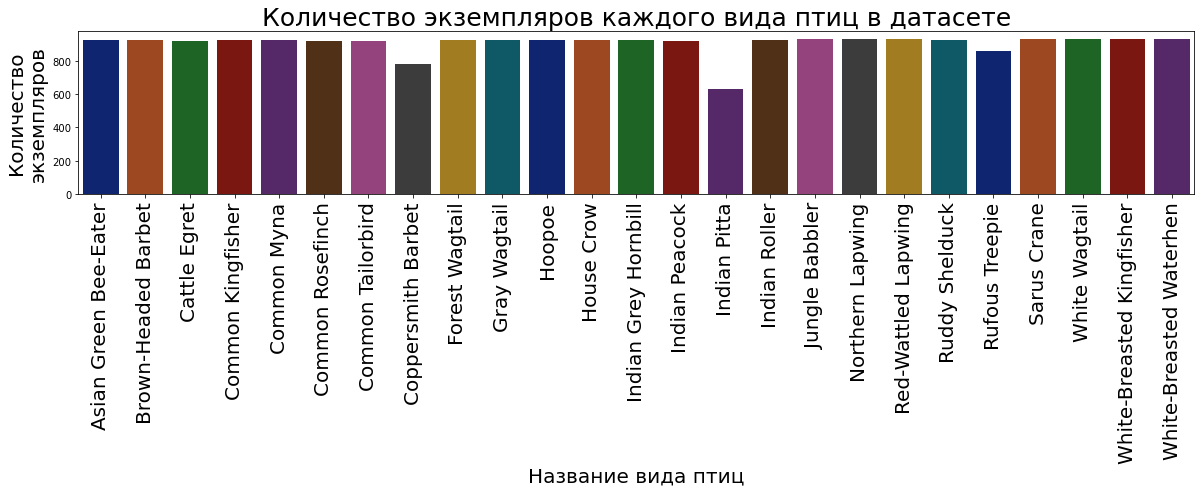

In [ ]:
df_classes = get_counts_by_class(dataset)
print(f"""Общее количество элементов в выборке {len(dataset.targets)}
Количество классов: {len(dataset.classes)}""")
barplot_(df_classes, fnt_x=20, figsize=(20,3))

Общее количество элементов в выборке 6000


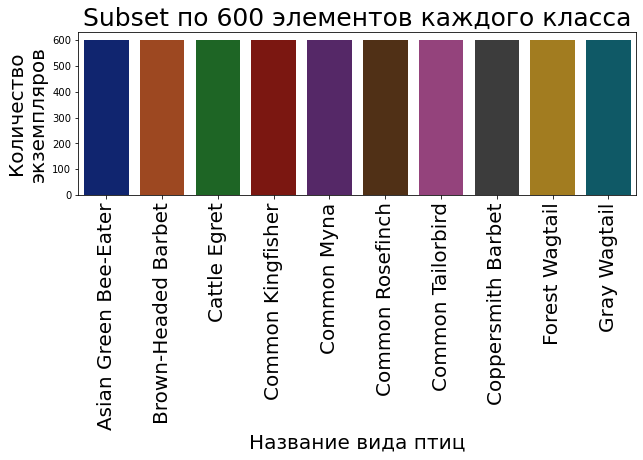

In [ ]:
df_classes = get_counts_by_class(dataset, subset)
print(f"""Общее количество элементов в выборке {len(subset.indices)}""")
barplot_(df_classes, figsize=(10,3),
         title=f"Subset по {len(subset.indices)//10} элементов каждого класса")

Общее количество элементов в тренировочной выборке 3600


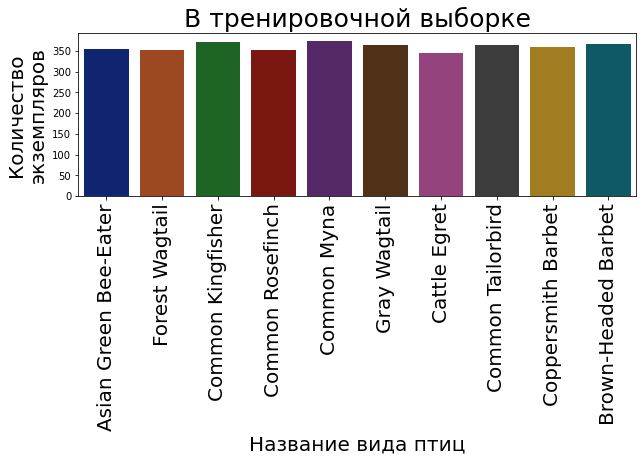

In [ ]:
df_classes = get_counts_by_class(dataset, train_set)
print(f"""Общее количество элементов в тренировочной выборке {len(train_set.indices)}""")
barplot_(df_classes,  figsize=(10,3),
         title="В тренировочной выборке")

Общее количество элементов в валидационной выборке 1200


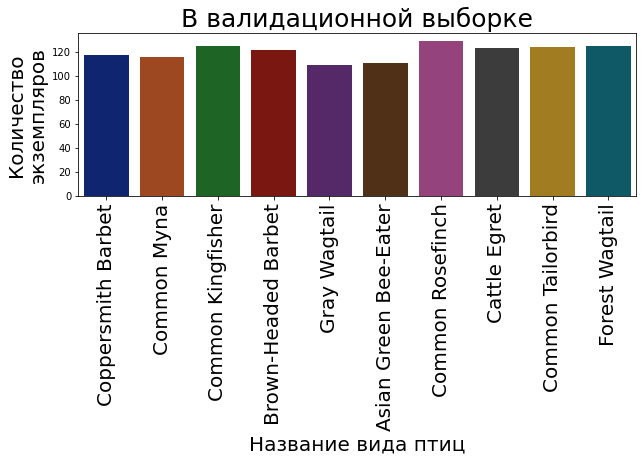

In [ ]:
df_classes = get_counts_by_class(dataset, validation_set)
print(f"""Общее количество элементов в валидационной выборке {len(validation_set.indices)}""")
barplot_(df_classes,  figsize=(10,3),
         title="В валидационной выборке")

Общее количество элементов в тестовой выборке 1200


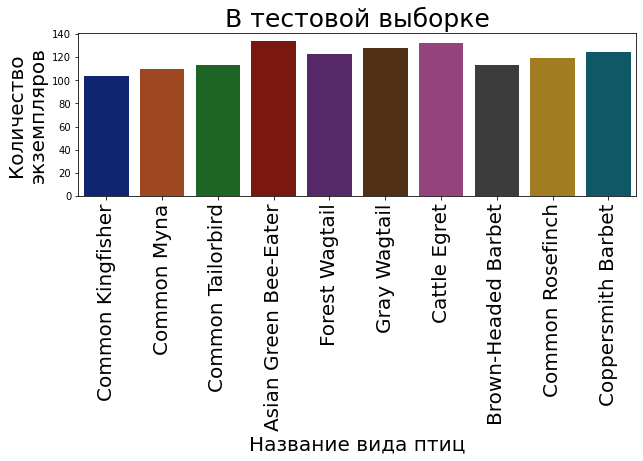

In [ ]:
df_classes = get_counts_by_class(dataset, test_set)
print(f"""Общее количество элементов в тестовой выборке {len(test_set.indices)}""")
barplot_(df_classes,  figsize=(10,3),
         title="В тестовой выборке")

Отсюда видно, что три класса представлены меньше остальных. Большинство классов представлены в равном количестве экземпляров.

Выведем несколько изображений из выборки на экран:

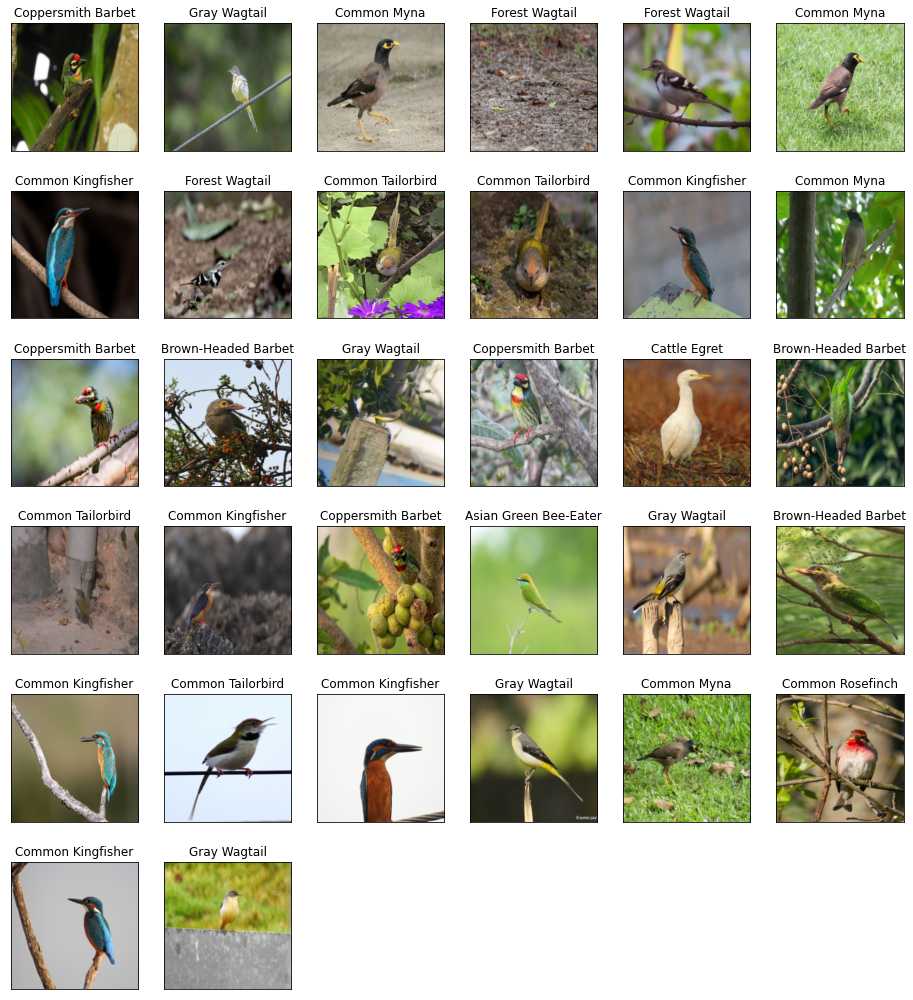

In [ ]:
for xi, yi in train_dl:
    show_batch_img(xi, yi, ncols=6)
    break

#### 3. При необходимости выполнить преобразование данных. Этот этап сильно зависит от типа исследуемых данных и может включать в себя токинизацию и векторизацию текста, извлечение признаков из данных, преобразование изображений в плоский численный массив и другие преобразования.

Данные загружаются в датасет и преобразовываются с помощью transforms средствами библиоткеи pytorch, с помощью класса Dataset. Данные (для удобства работы с ними и удобства обучения модели) разбиваются на батчи (batches) определенного объема (объем обусловлен в том числе ограниченностью ресурсов, предоставляемых google colab(далее это стало неважно, так как от google colab пришлось отказаться)). Данные в dataloaders хранятся батчами в следующем виде:
- (batch_size, channels, width, height)

<hr>

#### 4. Разделить набор данных на обучающую, тестовую и валидационную выборки. Обосновать количественные характеристики и метод разделения (временной, случайный, последовательный) выборки.

Данные разделены случайным образом в пропорции 60-20-20. Это отношение при разделении данных является наиболее часто используемым и оптимальным в виду достаточности данных. Все это позволяют делать встроенные функции библиотеки PyTorch.

<hr>

#### 5. Определить принципиальную архитектуру нейросетевой модели глубокого обучения, включая функцию ошибки и методы регуляризации, общую логику обучения модели. Предусмотреть возможные варианты модификации модели.

Так как обучение (да и проектирование) модели с нуля очень трудоемкий процесс, возьмем готовую и предобученную модель. Заменим слой - классификатор. Сначала просто 1280 выходных признаков будем преобразовывать сразу в классы, то есть создадим всего один полносвязный слой. Таким образом в модели не будет присутствовать дропаут и будет применено простейшее преобразование. Такое преобразование (ожидаемо) не должно дать точного результата. Обучение (даже при условии проектирования хорошей модели) с нуля займет также действительно много времени и потребуется несколько дней для обучения и сравнения моделей. А нам важна лишь часть с классификацией и дропаутом, поэтому выбрана была существующая предобученная модель. А вот выбор самих моделей на самом деле есть, а EfficientNetB0 была выбрана как относительно свежая и более легкая (по сравнению с давно придуманными и ставшими классикой) модель, что также важно для скорости обучения.

В качестве функции ошибки выбираем стандартную (классическую) функцию - Категориальную Кросс Энтропию, так как у нас задача классификации и эта функция является своего рода визитной карточкой в классификации.

В качестве оптимизатора выбираем Adam, так как он дает хорошую точность по сравнению с SGD или momentum, или adagrad.

<hr>

#### 6.	Реализовать модель с помощью фреймворка PyTorch. Реализация должна включать функционал загрузки данных, вывода промежуточных и финальных метрик качества и диагностических параметров процесса обучения модели. Реализация должна предусматривать гибкость, позволяющую выполнять ограниченную модификацию модели для выбора наилучшей из альтернативных архитектур.

Реализовано при помощи
- torchvision.models.efficentnet_b0
- torch.optim.Adam
- torch.nn.CrossEntropyLoss

#### 7.	Настроить параметры входных данных и параметров для обучения. Провести обучение модели на подготовленных входных данных используя выбранные настройки и алгоритмы обучения.

In [ ]:
effnet_b0_1 = models.efficientnet_b0(weights='IMAGENET1K_V1')
effnet_b0_1.classifier = nn.Sequential(
    nn.Linear(1280, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
#     nn.Dropout(p=0.45),
    nn.Linear(128, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
#     nn.Dropout(p=0.45),
    nn.Linear(256, 10),
    nn.Softmax(dim=1)
)
effnet_b0_1 = effnet_b0_1.to(device)
for param in effnet_b0_1.parameters():
    param.requires_grad = False
for param in effnet_b0_1.classifier.parameters():
    param.requires_grad = True

learnin_rate = 0.00005
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(effnet_b0_1.parameters(), lr=learnin_rate)

В функцию обучения передаем dataloader для тренировочной и валидационной выборки. Указываем количество эпох. patience задает количество итераций, через которые при ухудшении (неувеличении показателей) модели будет уменьшена скорость обучения. Early stopping задает количество эпох, через которое прервется обучение модели, если не будет найдет более хороший результат по сравнению с сохраненным лучшим. После обучения загружается модель с лучшими показателями.

In [ ]:
results1 = train_model(effnet_b0_1, train_dl, validation_dl, optimizer, criterion,
                       num_epochs=15, patience=3, early_stopping=5)

train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 1: model saved
#Эпоха [ 1]: train loss [244.6976], validation loss [77.4133], train accuracy [0.4281], validation accuracy [0.5942]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 2: model saved
#Эпоха [ 2]: train loss [223.6324], validation loss [72.2333], train accuracy [0.6394], validation accuracy [0.7075]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 3: model saved
#Эпоха [ 3]: train loss [212.1057], validation loss [68.8746], train accuracy [0.7144], validation accuracy [0.7758]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 4: model saved
#Эпоха [ 4]: train loss [204.4096], validation loss [67.0168], train accuracy [0.7619], validation accuracy [0.8083]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 5: model saved
#Эпоха [ 5]: train loss [199.5393], validation loss [65.3991], train accuracy [0.7894], validation accuracy [0.8275]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 6: model saved
#Эпоха [ 6]: train loss [194.6924], validation loss [64.7273], train accuracy [0.8175], validation accuracy [0.8258]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 7: model saved
#Эпоха [ 7]: train loss [192.2259], validation loss [63.7714], train accuracy [0.8275], validation accuracy [0.8442]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 8: model saved
#Эпоха [ 8]: train loss [190.9386], validation loss [63.2665], train accuracy [0.8319], validation accuracy [0.8433]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 9: model saved
#Эпоха [ 9]: train loss [188.6379], validation loss [63.2575], train accuracy [0.8492], validation accuracy [0.8458]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 10: model saved
#Эпоха [10]: train loss [187.2039], validation loss [62.7523], train accuracy [0.8581], validation accuracy [0.8567]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 11: model saved
#Эпоха [11]: train loss [185.6652], validation loss [62.4269], train accuracy [0.8697], validation accuracy [0.8558]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 12: model saved
#Эпоха [12]: train loss [184.6991], validation loss [62.3789], train accuracy [0.8722], validation accuracy [0.8608]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 13: model saved
#Эпоха [13]: train loss [183.4990], validation loss [62.1405], train accuracy [0.8803], validation accuracy [0.8575]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 14: model saved
#Эпоха [14]: train loss [182.4726], validation loss [62.0793], train accuracy [0.8922], validation accuracy [0.8558]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

#Эпоха [15]: train loss [181.4270], validation loss [62.0973], train accuracy [0.8933], validation accuracy [0.8567]
time: 55.15 minutes


#### 8.	Провести оценку качества модели с использованием предусмотренных метрик качества, проверить модель на переобучение.

Строим графики обучения для 4х метрик и функции ошибки. На них наглядно видно, как модель начивнает переобучаться и все сильнее подстраивается под тренировочную выборку, причем валидационная точность перестает расти. С увеличением количества эпох мы вряд ли добьемся большей точности, модель лишь сильнее подстроится под текущую выборку, теряя способность обобщать информацию.

In [ ]:
# #загрузка имеющихся результатов (по необходимости)
# with open('efficientnet_b0_1.pkl', 'rb') as fp:
#     results1 = pickle.load(fp)
# effnet_b0_1 = torch.load('efficientnet_b0_1.pth')

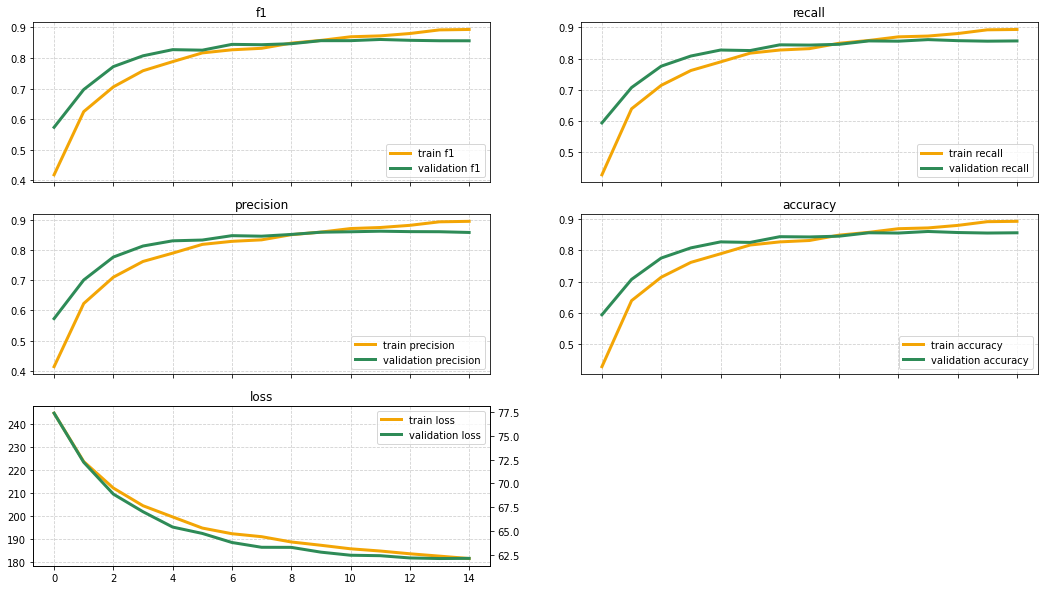

In [ ]:
plot_metrics(results1)

Далее получаем предсказанные и реальные значения на тестовой выборке и визуализируем результат.

In [ ]:
y_true, y_pred, loss = test(effnet_b0_1, test_dl, criterion)
y_true, y_pred = y_true.cpu(), y_pred.cpu()
metrcis1 = get_metrics(y_true, y_pred)

test:   0%|          | 0/38 [00:00<?, ?it/s]

С помощью встроенной функции визуализируем Precision, Recall и f1-score. Видим, что есть классы, для которых precision (количество действительно правильных из всех, отмеченных как правильные). Значит модель плохо обучилась на этот класс. Recall - если он меньше остальных, значит модель определяют все, как объекты этого класса, значит на этот класс она слишком сильно обучена. f1-score некоторая оценка на основе precision и recall и отображает результат с оглядкой на обе метрики. Чем лучше f1-score тем лучше результат в целом

In [ ]:
print(classification_report(y_true, y_pred, zero_division=0, target_names=dataset.classes[:10]))

              precision    recall  f1-score   support

         0.0       0.87      0.95      0.91       111
         1.0       0.71      0.80      0.75       121
         2.0       0.97      0.93      0.95       123
         3.0       0.97      0.89      0.92       125
         4.0       0.96      0.91      0.93       116
         5.0       0.80      0.75      0.77       129
         6.0       0.80      0.78      0.79       124
         7.0       0.82      0.76      0.79       117
         8.0       0.80      0.90      0.85       125
         9.0       0.93      0.92      0.92       109

    accuracy                           0.86      1200
   macro avg       0.86      0.86      0.86      1200
weighted avg       0.86      0.86      0.86      1200



Благодаря матрице ошибок можно более наглядно заметить результаты обучения модели. Видно, что Brown-Headed Barbet класс обучился в целом плохо. На нем низкий и precision и recall.

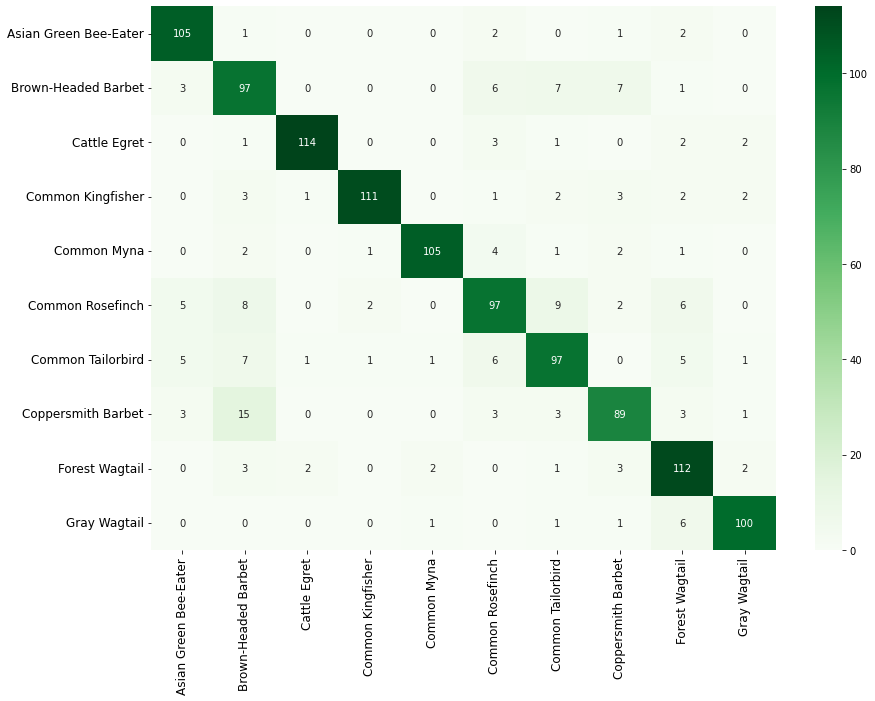

In [ ]:
heatmap_(y_true, y_pred, classes=dataset.classes)

Выведем изображение и результат работы нескольких слоев. Это поможет более наглядко увидеть как модель выделяет признаки из входного изображения.

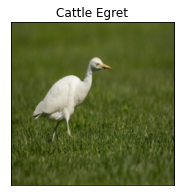

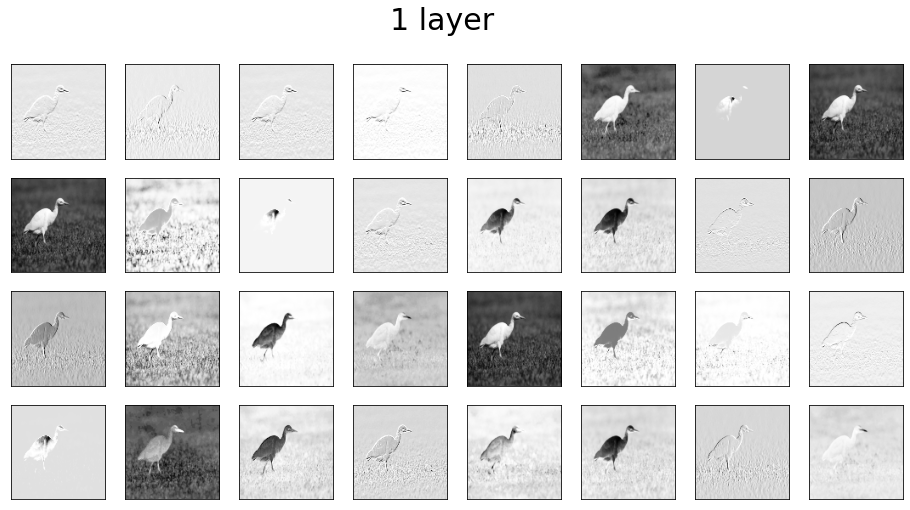

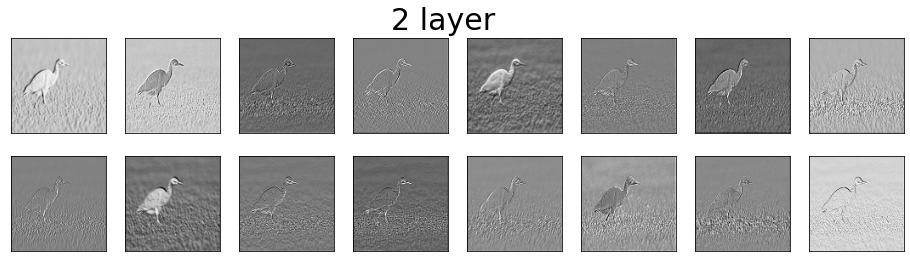

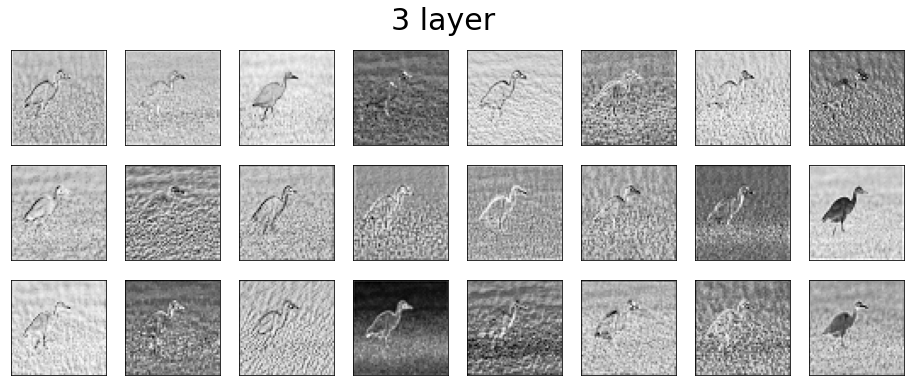

In [ ]:
show_layers_result(effnet_b0_1.features.children())

Сохраним модель и метрики, чтобы в случае, если необходимо будет построить графики заново - можно было бы это сделать, просто загрузив сохраненные результаты

In [ ]:
torch.save(effnet_b0_1, 'efficientnet_b0_1.pth')
with open('efficientnet_b0_1.pkl', 'wb') as fp:
    pickle.dump(results1, fp)

#### 9.	Провести обучение и оценку качества для несколько альтернативных архитектур (вариаций архитектур) моделей (не менее 3) для решения выбранной задачи. Проанализировать результаты, сделать выводы, в том числе определить наилучшую архитектуру.

##### Первый вариант модели с дропаутом
В данной модели использовалась вероятность дропаута 20%. Все остальные условия остаются теми же. Оптимизатор, скорость обучения, натренированная модель, ее веса, архитектура (кроме классификатора), функция ошибки, фукнция тренировки (количество эпох).

In [ ]:
effnet_b0_2 = models.efficientnet_b0(weights='IMAGENET1K_V1')
effnet_b0_2.classifier = nn.Sequential(
    nn.Linear(1280, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Dropout(p=0.2),
    nn.Linear(128, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(p=0.2),
    nn.Linear(256, 10),
    nn.Softmax(dim=1)
)
effnet_b0_2 = effnet_b0_2.to(device)
for param in effnet_b0_2.parameters():
    param.requires_grad = False
for param in effnet_b0_2.classifier.parameters():
    param.requires_grad = True

learnin_rate = 0.00005
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(effnet_b0_2.parameters(), lr=learnin_rate)

In [ ]:
results2 = train_model(effnet_b0_2, train_dl, validation_dl, optimizer, criterion,
                       num_epochs=15, patience=3, early_stopping=5)

train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 1: model saved
#Эпоха [ 1]: train loss [253.8250], validation loss [81.3687], train accuracy [0.2753], validation accuracy [0.5000]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 2: model saved
#Эпоха [ 2]: train loss [235.2170], validation loss [75.5985], train accuracy [0.5358], validation accuracy [0.6308]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 3: model saved
#Эпоха [ 3]: train loss [221.9217], validation loss [71.6765], train accuracy [0.6328], validation accuracy [0.7250]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 4: model saved
#Эпоха [ 4]: train loss [213.6697], validation loss [69.4890], train accuracy [0.6900], validation accuracy [0.7633]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 5: model saved
#Эпоха [ 5]: train loss [206.8174], validation loss [67.5832], train accuracy [0.7464], validation accuracy [0.7933]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 6: model saved
#Эпоха [ 6]: train loss [202.6213], validation loss [66.1751], train accuracy [0.7650], validation accuracy [0.8108]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 7: model saved
#Эпоха [ 7]: train loss [199.3578], validation loss [64.9295], train accuracy [0.7811], validation accuracy [0.8233]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 8: model saved
#Эпоха [ 8]: train loss [196.3504], validation loss [64.5772], train accuracy [0.7944], validation accuracy [0.8258]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 9: model saved
#Эпоха [ 9]: train loss [194.3907], validation loss [63.6719], train accuracy [0.8094], validation accuracy [0.8442]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 10: model saved
#Эпоха [10]: train loss [192.1381], validation loss [63.5558], train accuracy [0.8261], validation accuracy [0.8467]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 11: model saved
#Эпоха [11]: train loss [190.4377], validation loss [63.3016], train accuracy [0.8386], validation accuracy [0.8467]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 12: model saved
#Эпоха [12]: train loss [189.6859], validation loss [62.9172], train accuracy [0.8294], validation accuracy [0.8492]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 13: model saved
#Эпоха [13]: train loss [188.8065], validation loss [62.6399], train accuracy [0.8339], validation accuracy [0.8600]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 14: model saved
#Эпоха [14]: train loss [187.0509], validation loss [62.2742], train accuracy [0.8539], validation accuracy [0.8667]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

#Эпоха [15]: train loss [186.2509], validation loss [62.2906], train accuracy [0.8592], validation accuracy [0.8567]
time: 54.99 minutes


Видим, что валидационная точность хотя и начинает сравниваться с тестовой, но так и не сравнялась, причем точность продолжает расти, это говорит о том, что модель не потеряла способности обобщать признаки и не подстраивается под конктретное тренировочное множество. Такое медленное обучение связано с особенностью данных (почему-то модель очень плохо различает и обучается (недообучается) на второй класс (Brown-headed barbet)). И вот медленное возрастание точности как раз таки связано с тем, что модель начинается подстраиваться к этому классу (вывод сделан на основе многих тестов). Чем больше модель обучается, тем лучше она распознает этот класс, но переобучение не происходит. Почему изначально этот класс так страдает - сказать не могу. И второй класс, на который модель переобучается - Common Rosefinch.

In [ ]:
# #загрузка имеющихся результатов
# with open('efficientnet_b0_2.pkl', 'rb') as fp:
#     results2 = pickle.load(fp)
# effnet_b0_2 = torch.load('efficientnet_b0_2.pth')

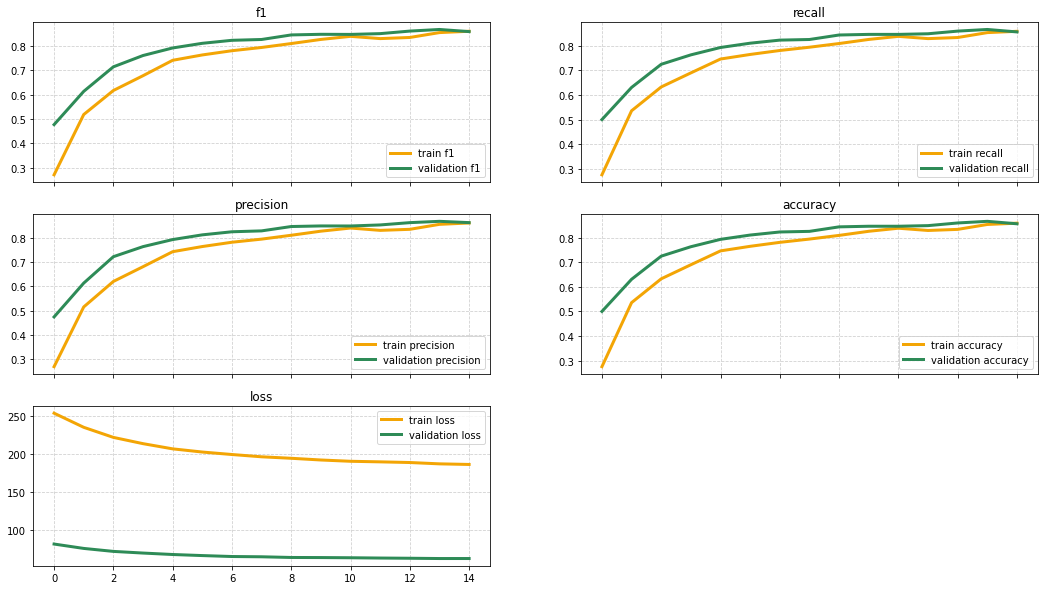

In [ ]:
plot_metrics(results2)

In [ ]:
y_true, y_pred, loss = test(effnet_b0_2, test_dl, criterion)
y_true, y_pred = y_true.cpu(), y_pred.cpu()
metrcis2 = get_metrics(y_true, y_pred)

test:   0%|          | 0/38 [00:00<?, ?it/s]

In [ ]:
print(classification_report(y_true, y_pred, zero_division=0, target_names=dataset.classes[:10]))

              precision    recall  f1-score   support

         0.0       0.86      0.93      0.89       111
         1.0       0.74      0.79      0.77       121
         2.0       0.94      0.96      0.95       123
         3.0       0.96      0.91      0.93       125
         4.0       0.93      0.95      0.94       116
         5.0       0.80      0.79      0.79       129
         6.0       0.84      0.80      0.82       124
         7.0       0.83      0.78      0.81       117
         8.0       0.88      0.90      0.89       125
         9.0       0.90      0.86      0.88       109

    accuracy                           0.87      1200
   macro avg       0.87      0.87      0.87      1200
weighted avg       0.87      0.87      0.87      1200



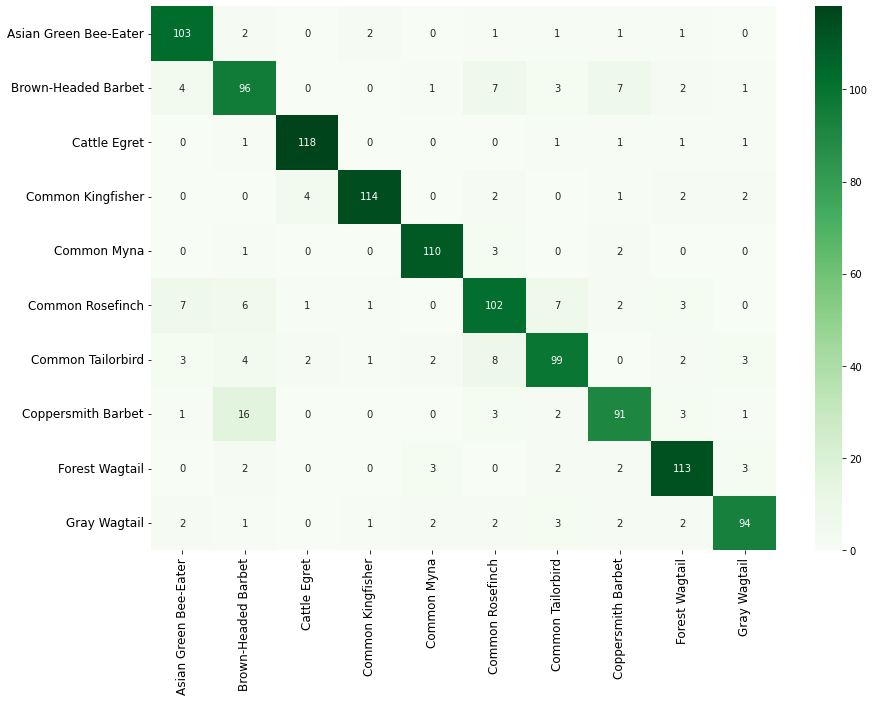

In [ ]:
heatmap_(y_true, y_pred, classes=dataset.classes)

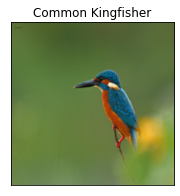

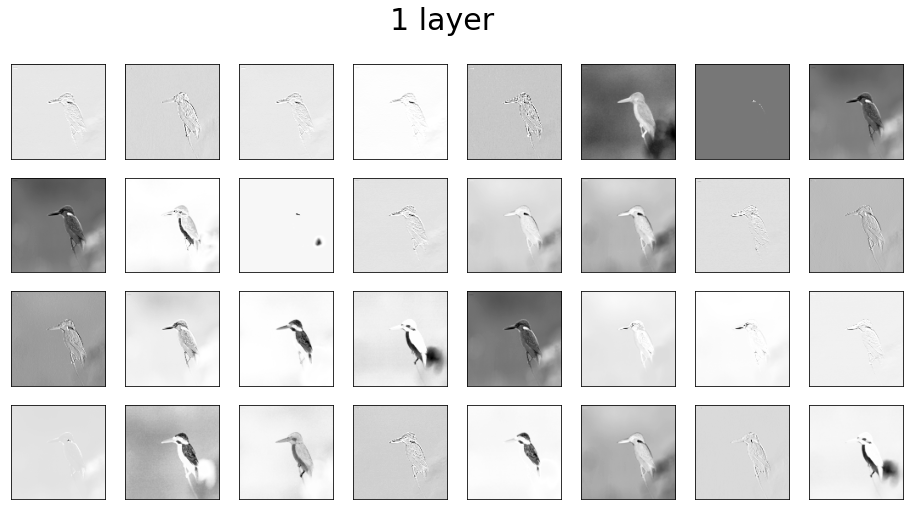

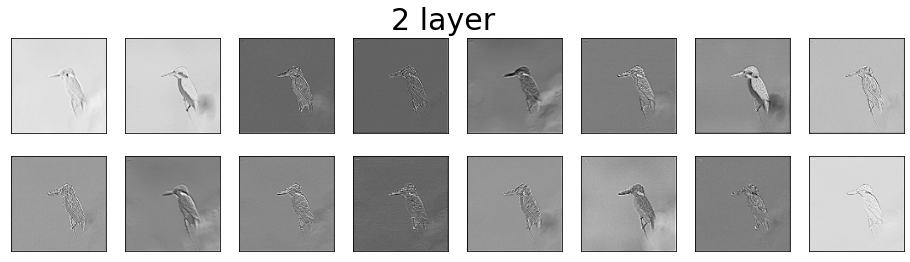

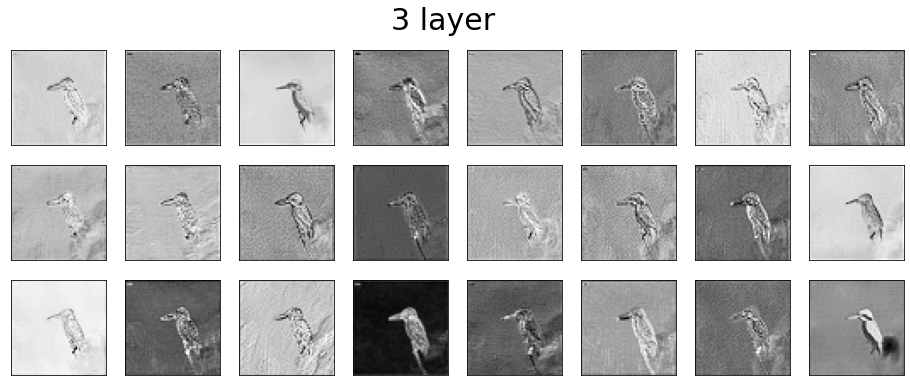

In [ ]:
show_layers_result(effnet_b0_2.features.children())

In [ ]:
torch.save(effnet_b0_2, 'efficientnet_b0_2.pth')
with open('efficientnet_b0_2.pkl', 'wb') as fp:
    pickle.dump(results2, fp)

##### Второй вариант модели с дропаутом

В данной модели вероятность дропаута уже 45%. Все остальные условия остаются теми же. Оптимизатор, скорость обучения, предтренированная модель, ее веса, архитектура (кроме классификатора), функция ошибки, фукнция тренировки (количество эпох).

In [ ]:
effnet_b0_3 = models.efficientnet_b0(weights='IMAGENET1K_V1')
effnet_b0_3.classifier = nn.Sequential(
    nn.Linear(1280, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Dropout(p=0.45),
    nn.Linear(128, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(p=0.45),
    nn.Linear(256, 10),
    nn.Softmax(dim=1)
)
effnet_b0_3 = effnet_b0_3.to(device)
for param in effnet_b0_3.parameters():
    param.requires_grad = False
for param in effnet_b0_3.classifier.parameters():
    param.requires_grad = True

learnin_rate = 0.00005
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(effnet_b0_3.parameters(), lr=learnin_rate)

In [ ]:
results3 = train_model(effnet_b0_3, train_dl, validation_dl, optimizer, criterion,
                       num_epochs=30, patience=3, early_stopping=5)

train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 1: model saved
#Эпоха [ 1]: train loss [257.5627], validation loss [84.9098], train accuracy [0.1700], validation accuracy [0.4150]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 2: model saved
#Эпоха [ 2]: train loss [248.5416], validation loss [80.3438], train accuracy [0.3500], validation accuracy [0.5583]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 3: model saved
#Эпоха [ 3]: train loss [237.5492], validation loss [76.2419], train accuracy [0.4822], validation accuracy [0.6233]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 4: model saved
#Эпоха [ 4]: train loss [229.0153], validation loss [73.8696], train accuracy [0.5531], validation accuracy [0.6750]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 5: model saved
#Эпоха [ 5]: train loss [222.7315], validation loss [71.4708], train accuracy [0.5986], validation accuracy [0.7250]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 6: model saved
#Эпоха [ 6]: train loss [216.9452], validation loss [70.2237], train accuracy [0.6478], validation accuracy [0.7417]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 7: model saved
#Эпоха [ 7]: train loss [212.6016], validation loss [68.7258], train accuracy [0.6917], validation accuracy [0.7733]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 8: model saved
#Эпоха [ 8]: train loss [209.8706], validation loss [67.2871], train accuracy [0.7017], validation accuracy [0.7958]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 9: model saved
#Эпоха [ 9]: train loss [205.7718], validation loss [66.4796], train accuracy [0.7331], validation accuracy [0.8133]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 10: model saved
#Эпоха [10]: train loss [202.1889], validation loss [65.4958], train accuracy [0.7642], validation accuracy [0.8317]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 11: model saved
#Эпоха [11]: train loss [201.0541], validation loss [65.2417], train accuracy [0.7569], validation accuracy [0.8250]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 12: model saved
#Эпоха [12]: train loss [198.8320], validation loss [64.5665], train accuracy [0.7711], validation accuracy [0.8417]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 13: model saved
#Эпоха [13]: train loss [196.9280], validation loss [63.8710], train accuracy [0.7911], validation accuracy [0.8467]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 14: model saved
#Эпоха [14]: train loss [196.0082], validation loss [63.5620], train accuracy [0.7883], validation accuracy [0.8508]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 15: model saved
#Эпоха [15]: train loss [194.5702], validation loss [63.3682], train accuracy [0.7997], validation accuracy [0.8483]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 16: model saved
#Эпоха [16]: train loss [193.4541], validation loss [63.1910], train accuracy [0.8050], validation accuracy [0.8450]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 17: model saved
#Эпоха [17]: train loss [192.5819], validation loss [62.9316], train accuracy [0.8100], validation accuracy [0.8450]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 18: model saved
#Эпоха [18]: train loss [191.6262], validation loss [62.7040], train accuracy [0.8153], validation accuracy [0.8525]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 19: model saved
#Эпоха [19]: train loss [191.3605], validation loss [62.5419], train accuracy [0.8128], validation accuracy [0.8600]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 20: model saved
#Эпоха [20]: train loss [189.8607], validation loss [62.2615], train accuracy [0.8253], validation accuracy [0.8558]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 21: model saved
#Эпоха [21]: train loss [189.2608], validation loss [62.2020], train accuracy [0.8281], validation accuracy [0.8575]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 22: model saved
#Эпоха [22]: train loss [188.7356], validation loss [62.1763], train accuracy [0.8328], validation accuracy [0.8517]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 23: model saved
#Эпоха [23]: train loss [188.1193], validation loss [62.0503], train accuracy [0.8394], validation accuracy [0.8675]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 24: model saved
#Эпоха [24]: train loss [187.2315], validation loss [61.9221], train accuracy [0.8386], validation accuracy [0.8642]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

#Эпоха [25]: train loss [187.0516], validation loss [62.1021], train accuracy [0.8414], validation accuracy [0.8592]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

#Эпоха [26]: train loss [185.5993], validation loss [62.0548], train accuracy [0.8547], validation accuracy [0.8542]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 27: model saved
#Эпоха [27]: train loss [186.4832], validation loss [61.6668], train accuracy [0.8472], validation accuracy [0.8617]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

#Эпоха [28]: train loss [185.6755], validation loss [61.9212], train accuracy [0.8544], validation accuracy [0.8567]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

#Эпоха [29]: train loss [185.4188], validation loss [61.9127], train accuracy [0.8519], validation accuracy [0.8575]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 30: model saved
#Эпоха [30]: train loss [185.4754], validation loss [61.4596], train accuracy [0.8447], validation accuracy [0.8633]
time: 108.91 minutes


Для достижения того же результата потребовалось гораздо больше эпох и времени.

In [ ]:
# #загрузка имеющихся результатов
# with open('efficientnet_b0_3.pkl', 'rb') as fp:
#     results3 = pickle.load(fp)
# effnet_b0_3 = torch.load('efficientnet_b0_3.pth')

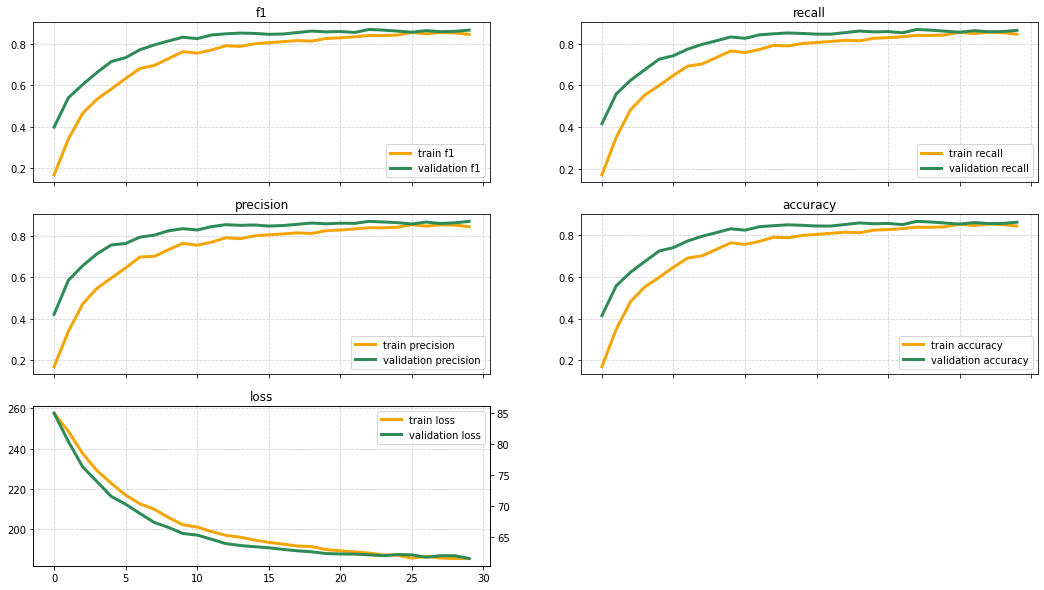

In [ ]:
plot_metrics(results3)

In [ ]:
y_true, y_pred, loss = test(effnet_b0_3, test_dl, criterion)
y_true, y_pred = y_true.cpu(), y_pred.cpu()
metrcis3 = get_metrics(y_true, y_pred)

test:   0%|          | 0/38 [00:00<?, ?it/s]

In [ ]:
print(classification_report(y_true, y_pred, zero_division=0, target_names=dataset.classes[:10]))

              precision    recall  f1-score   support

         0.0       0.91      0.90      0.90       111
         1.0       0.68      0.84      0.75       121
         2.0       0.95      0.94      0.95       123
         3.0       0.95      0.88      0.91       125
         4.0       0.94      0.93      0.94       116
         5.0       0.86      0.74      0.80       129
         6.0       0.82      0.82      0.82       124
         7.0       0.75      0.84      0.79       117
         8.0       0.92      0.86      0.89       125
         9.0       0.94      0.88      0.91       109

    accuracy                           0.86      1200
   macro avg       0.87      0.86      0.87      1200
weighted avg       0.87      0.86      0.87      1200



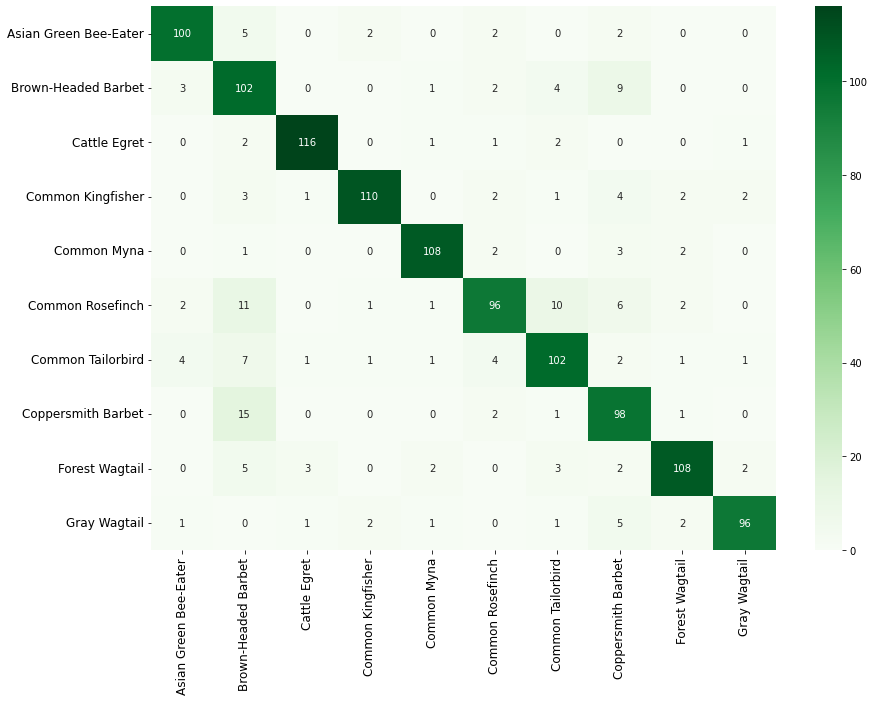

In [ ]:
heatmap_(y_true, y_pred, classes=dataset.classes)

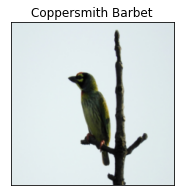

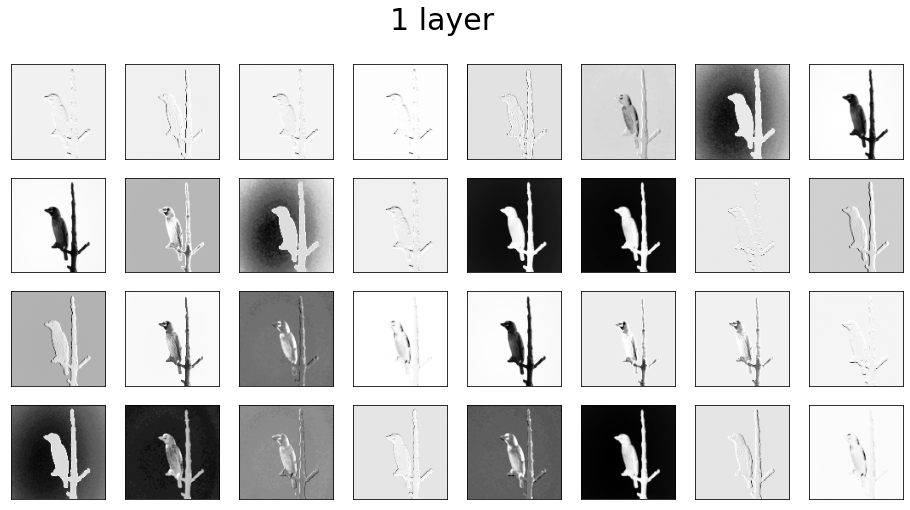

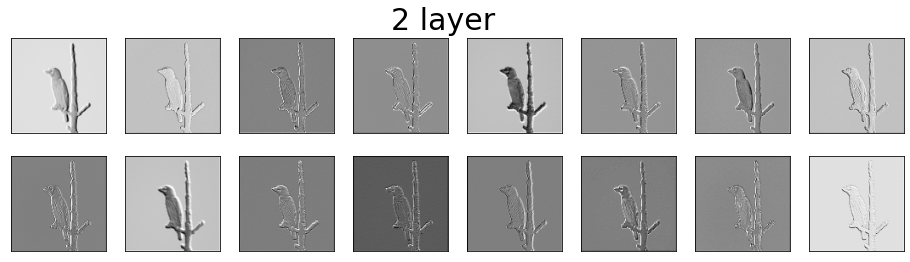

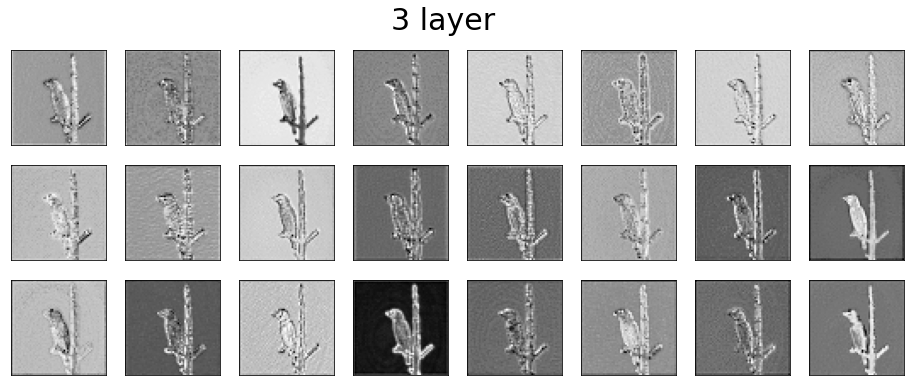

In [ ]:
show_layers_result(effnet_b0_3.features.children())

In [ ]:
torch.save(effnet_b0_3, 'efficientnet_b0_3.pth')
with open('efficientnet_b0_3.pkl', 'wb') as fp:
    pickle.dump(results3, fp)

#### Третий вариант модели с дропаутом

Все характеристики прежние, кроме того, что вероятность дропаута теперь 80%.

In [ ]:
effnet_b0_4 = models.efficientnet_b0(weights='IMAGENET1K_V1')
effnet_b0_4.classifier = nn.Sequential(
    nn.Linear(1280, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Dropout(p=0.8),
    nn.Linear(128, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(p=0.8),
    nn.Linear(256, 10),
    nn.Softmax(dim=1)
)
effnet_b0_4 = effnet_b0_4.to(device)
for param in effnet_b0_4.parameters():
    param.requires_grad = False
for param in effnet_b0_4.classifier.parameters():
    param.requires_grad = True

learnin_rate = 0.00005
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(effnet_b0_4.parameters(), lr=learnin_rate)

In [ ]:
results4 = train_model(effnet_b0_4, train_dl, validation_dl, optimizer, criterion,
                       num_epochs=45, patience=3, early_stopping=5)

train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 1: model saved
#Эпоха [ 1]: train loss [260.7664], validation loss [87.2193], train accuracy [0.1092], validation accuracy [0.1433]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 2: model saved
#Эпоха [ 2]: train loss [259.9795], validation loss [86.7486], train accuracy [0.1183], validation accuracy [0.2225]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 3: model saved
#Эпоха [ 3]: train loss [258.5568], validation loss [86.3029], train accuracy [0.1389], validation accuracy [0.3325]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 4: model saved
#Эпоха [ 4]: train loss [257.3841], validation loss [85.5687], train accuracy [0.1592], validation accuracy [0.4233]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 5: model saved
#Эпоха [ 5]: train loss [255.7702], validation loss [84.7815], train accuracy [0.1822], validation accuracy [0.4758]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 6: model saved
#Эпоха [ 6]: train loss [254.3235], validation loss [84.0171], train accuracy [0.2019], validation accuracy [0.5175]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 7: model saved
#Эпоха [ 7]: train loss [253.2598], validation loss [82.7421], train accuracy [0.2153], validation accuracy [0.5467]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 8: model saved
#Эпоха [ 8]: train loss [250.2786], validation loss [81.7740], train accuracy [0.2556], validation accuracy [0.5658]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 9: model saved
#Эпоха [ 9]: train loss [248.8238], validation loss [80.3387], train accuracy [0.2792], validation accuracy [0.5783]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 10: model saved
#Эпоха [10]: train loss [246.6810], validation loss [79.6823], train accuracy [0.3006], validation accuracy [0.5967]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 11: model saved
#Эпоха [11]: train loss [244.4654], validation loss [78.7277], train accuracy [0.3256], validation accuracy [0.6017]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 12: model saved
#Эпоха [12]: train loss [242.9535], validation loss [78.0425], train accuracy [0.3408], validation accuracy [0.6108]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 13: model saved
#Эпоха [13]: train loss [240.5183], validation loss [77.1704], train accuracy [0.3669], validation accuracy [0.6092]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 14: model saved
#Эпоха [14]: train loss [239.2726], validation loss [76.2489], train accuracy [0.3786], validation accuracy [0.6133]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 15: model saved
#Эпоха [15]: train loss [237.4912], validation loss [75.7966], train accuracy [0.3919], validation accuracy [0.6217]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 16: model saved
#Эпоха [16]: train loss [235.9641], validation loss [75.0462], train accuracy [0.4181], validation accuracy [0.6358]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 17: model saved
#Эпоха [17]: train loss [235.3006], validation loss [74.2260], train accuracy [0.4131], validation accuracy [0.6392]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 18: model saved
#Эпоха [18]: train loss [233.7722], validation loss [73.8348], train accuracy [0.4294], validation accuracy [0.6350]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 19: model saved
#Эпоха [19]: train loss [232.2873], validation loss [73.2488], train accuracy [0.4456], validation accuracy [0.6408]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 20: model saved
#Эпоха [20]: train loss [230.9939], validation loss [72.9336], train accuracy [0.4567], validation accuracy [0.6425]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 21: model saved
#Эпоха [21]: train loss [230.0718], validation loss [72.6513], train accuracy [0.4722], validation accuracy [0.6433]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 22: model saved
#Эпоха [22]: train loss [229.9423], validation loss [71.8026], train accuracy [0.4689], validation accuracy [0.6533]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

#Эпоха [23]: train loss [227.2322], validation loss [72.0988], train accuracy [0.4900], validation accuracy [0.6592]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 24: model saved
#Эпоха [24]: train loss [226.9117], validation loss [71.1357], train accuracy [0.4869], validation accuracy [0.6675]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 25: model saved
#Эпоха [25]: train loss [225.0203], validation loss [71.0080], train accuracy [0.5147], validation accuracy [0.6625]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 26: model saved
#Эпоха [26]: train loss [224.8441], validation loss [70.7551], train accuracy [0.5106], validation accuracy [0.6700]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 27: model saved
#Эпоха [27]: train loss [224.2814], validation loss [70.5466], train accuracy [0.5119], validation accuracy [0.6742]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 28: model saved
#Эпоха [28]: train loss [222.9524], validation loss [70.5212], train accuracy [0.5264], validation accuracy [0.6742]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 29: model saved
#Эпоха [29]: train loss [222.1791], validation loss [70.1067], train accuracy [0.5383], validation accuracy [0.6792]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 30: model saved
#Эпоха [30]: train loss [220.6257], validation loss [70.0861], train accuracy [0.5472], validation accuracy [0.6750]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 31: model saved
#Эпоха [31]: train loss [220.4880], validation loss [69.5942], train accuracy [0.5450], validation accuracy [0.6858]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 32: model saved
#Эпоха [32]: train loss [219.9052], validation loss [69.4393], train accuracy [0.5542], validation accuracy [0.6892]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 33: model saved
#Эпоха [33]: train loss [219.0887], validation loss [68.9493], train accuracy [0.5661], validation accuracy [0.7100]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 34: model saved
#Эпоха [34]: train loss [217.8459], validation loss [68.5820], train accuracy [0.5789], validation accuracy [0.7133]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

#Эпоха [35]: train loss [217.6843], validation loss [69.0567], train accuracy [0.5711], validation accuracy [0.7025]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 36: model saved
#Эпоха [36]: train loss [217.7570], validation loss [68.4253], train accuracy [0.5747], validation accuracy [0.7275]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 37: model saved
#Эпоха [37]: train loss [215.1047], validation loss [68.0226], train accuracy [0.6042], validation accuracy [0.7292]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

#Эпоха [38]: train loss [215.3351], validation loss [68.0344], train accuracy [0.6017], validation accuracy [0.7342]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 39: model saved
#Эпоха [39]: train loss [214.8867], validation loss [67.6656], train accuracy [0.6028], validation accuracy [0.7392]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 40: model saved
#Эпоха [40]: train loss [214.2081], validation loss [67.5357], train accuracy [0.6025], validation accuracy [0.7417]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 41: model saved
#Эпоха [41]: train loss [213.7383], validation loss [67.1974], train accuracy [0.6178], validation accuracy [0.7525]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 42: model saved
#Эпоха [42]: train loss [213.1320], validation loss [66.8327], train accuracy [0.6147], validation accuracy [0.7575]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 43: model saved
#Эпоха [43]: train loss [213.4039], validation loss [66.7451], train accuracy [0.6219], validation accuracy [0.7667]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

#Эпоха [44]: train loss [211.9532], validation loss [66.7544], train accuracy [0.6339], validation accuracy [0.7625]


train:   0%|          | 0/113 [00:00<?, ?it/s]

test:   0%|          | 0/38 [00:00<?, ?it/s]

epoch 45: model saved
#Эпоха [45]: train loss [211.8638], validation loss [66.4659], train accuracy [0.6231], validation accuracy [0.7775]
time: 167.81 minutes


Обучение модели теперь идет еще дольше, чем в предыдущем случае и требуется гораздо больше эпох. А результат в целом остается почти такой же.

In [ ]:
# #загрузка имеющихся результатов
# with open('efficientnet_b0_4.pkl', 'rb') as fp:
#     results4 = pickle.load(fp)
# effnet_b0_4 = torch.load('efficientnet_b0_4.pth')

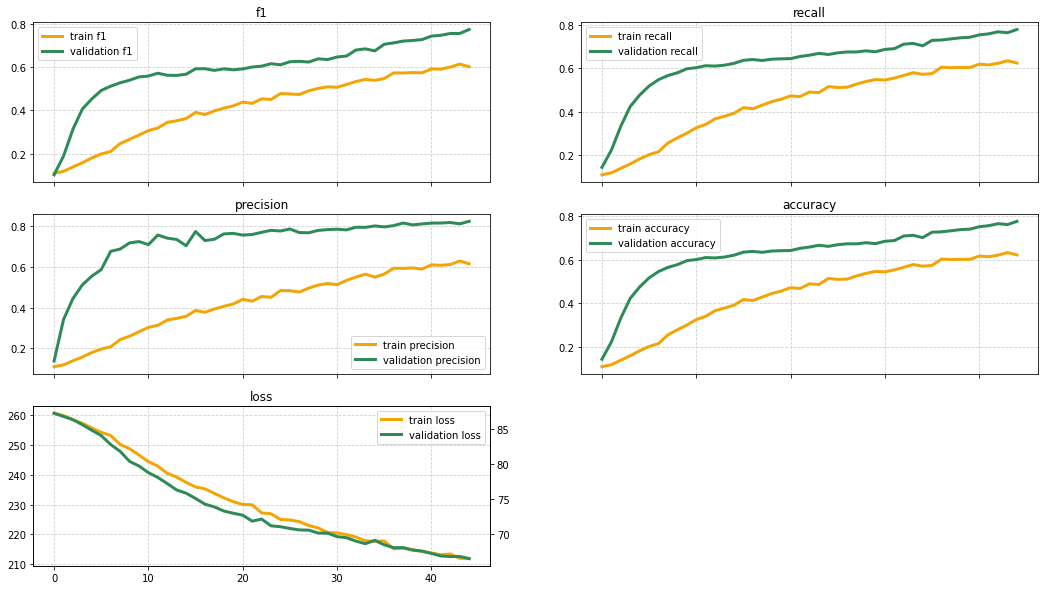

In [ ]:
plot_metrics(results4)

In [ ]:
y_true, y_pred, loss = test(effnet_b0_4, test_dl, criterion)
y_true, y_pred = y_true.cpu(), y_pred.cpu()
metrcis4 = get_metrics(y_true, y_pred)

test:   0%|          | 0/38 [00:00<?, ?it/s]

In [ ]:
print(classification_report(y_true, y_pred, zero_division=0, target_names=dataset.classes[:10]))

                       precision    recall  f1-score   support

Asian Green Bee-Eater       0.74      0.92      0.82       111
  Brown-Headed Barbet       0.46      0.90      0.61       121
         Cattle Egret       0.95      0.92      0.93       123
    Common Kingfisher       0.97      0.89      0.92       125
          Common Myna       0.89      0.92      0.91       116
     Common Rosefinch       0.77      0.50      0.60       129
    Common Tailorbird       0.88      0.55      0.68       124
   Coppersmith Barbet       0.98      0.41      0.58       117
       Forest Wagtail       0.79      0.90      0.84       125
         Gray Wagtail       0.81      0.91      0.86       109

             accuracy                           0.78      1200
            macro avg       0.82      0.78      0.78      1200
         weighted avg       0.83      0.78      0.77      1200



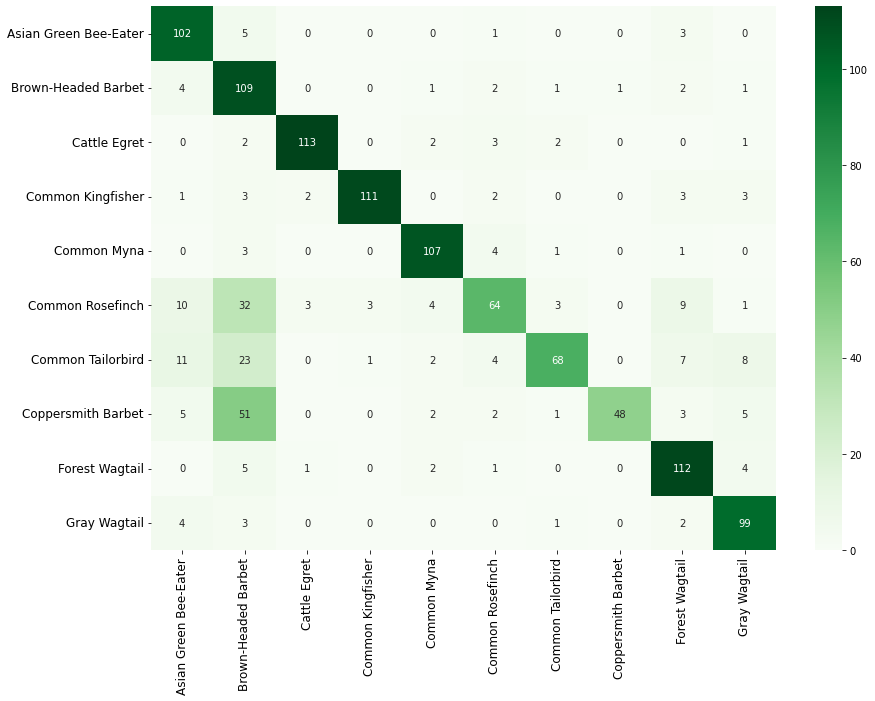

In [ ]:
heatmap_(y_true, y_pred, classes=dataset.classes)

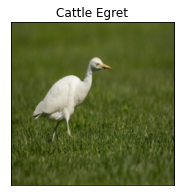

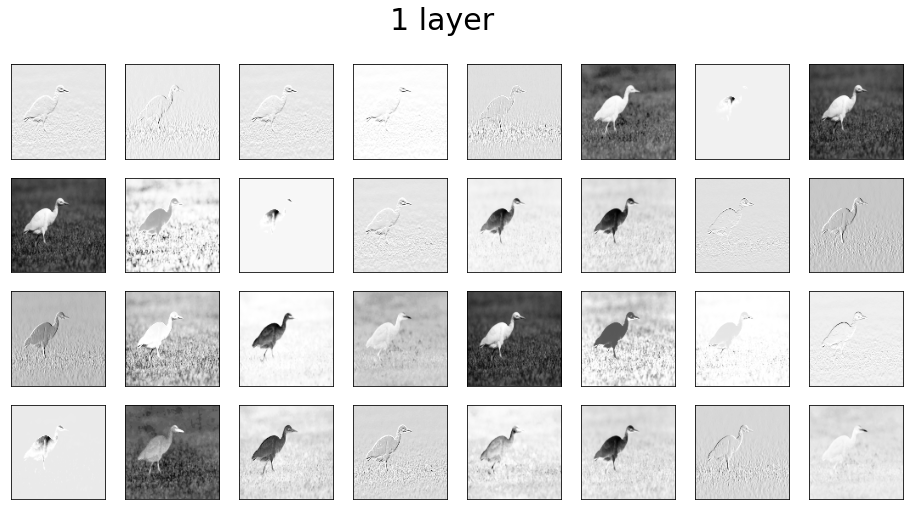

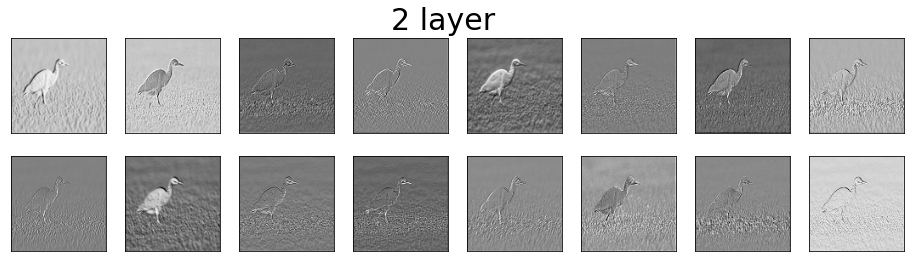

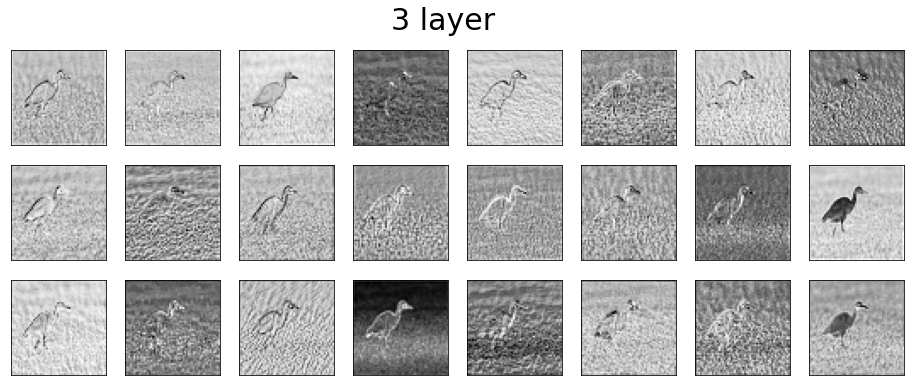

In [ ]:
show_layers_result(effnet_b0_4.features.children())

In [ ]:
torch.save(effnet_b0_4, 'efficientnet_b0_4.pth')
with open('efficientnet_b0_4', 'wb') as fp:
    pickle.dump(results4, fp)

### Общие выводы по работе

Дропаут безусловно помогает избежать проблемы переобучения сетей, но им не стоит злоупотреблять, ведь это увеличит необходимое время для обучения модели. А в данном случае он практически не дает увеличения точности модели, потому что скорее всего показатель точности упирается в другие проблемы модели, не связанные с обучением. Возможно стоит применить другой оптимизатор, или использовать другую фукнцию ошибки, или понизить скорость обучения, что позволит более точно подстроиться модели.

In [ ]:
results = [results1, results2, results3, results4]

In [ ]:
df1 = pd.DataFrame(
    [(i+1, p, int(time_/60)) for (i, (df, time_)), p in zip(
        enumerate(results), [0, 0.2, 0.45, 0.8])],
    columns=["№ модели", "p", "Время, мин."]
)
df2 = pd.DataFrame([metrcis1, metrcis2, metrcis3, metrcis4],
            columns=metrics__[1:])
df = pd.concat([df1, df2.round(3)], axis=1)

In [ ]:
df

№ модели     p  Время, мин.  accuracy  precision  recall     f1
0         1  0.00           55     0.856      0.860   0.856  0.857
1         2  0.20           54     0.867      0.867   0.867  0.867
2         3  0.45          108     0.863      0.871   0.863  0.865
3         4  0.80          167     0.778      0.825   0.778  0.774

Видно, что метрики по первым трем моделям практически не отличаются. Для второй и третьей модели они вообще можно сказать равны. Следовательно, учитывая время обучения модели, можно было бы взять во внимание, что второй вариант самый оптимальный.